In [2]:
import numpy as np
import scipy.signal
import os
from matplotlib import pyplot as plt 

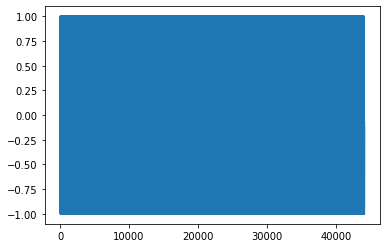

In [3]:
#from scipy.io import wavfile
#fs_wav, data_wav = wavfile.read("./data/filename.wav")
blockSize=1024
hopSize=512
fs=44100


f1=441
f2=882
t=1
samples1=np.arange(t * 44100)
samples2=np.arange(t * 44100)
sig_a=np.sin(2*np.pi*f1*samples1/fs)
sig_b=np.sin(2*np.pi*f2*samples2/fs)
sig=np.append(sig_a,sig_b)
samples=np.append(samples1,samples2)

#plt.title("Matplotlib demo") 
#plt.xlabel("x axis caption") 
#plt.ylabel("y axis caption") 
plt.plot(samples,sig)
plt.show()

In [4]:
def block_audio(x,blockSize,hopSize,fs):
    # Implement a function block_audio(x,blockSize,hopSize,fs) which returns
    # a matrix xb (dimension NumOfBlocks X blockSize) and a vector timeInSec (dimension NumOfBlocks) 
    # for blocking the input audio signal into overlapping blocks. timeInSec will refer to the start time of each block. 
    # Do not use any helper functions such as stride.

    #Returns a matrix [numBlocks * blockSize] and starttimeinsecs [numBlocks]
    a=1
    file_length=x.shape[0]
    numBlocks=np.ceil(file_length/hopSize).astype(int)
    #numBlocks = np.floor((file_length-blockSize)/hopSize + 1).astype(int) # throws error if not cast as int (PUT MORE DETAILED COMMENTS)
    numZeroes= hopSize-(file_length%hopSize)# file_length-[(hopSize*numBlocks) ]
    x=np.append(x,np.zeros(numZeroes))
    i=0
    lst=[]
    ts=[]
    for blk in range(0,numBlocks):
        if i == 0:
            start = 0
            i=i+1
        end = start + blockSize
        lst.append(x[start:end])
        #print(start)
        ts.append(start/fs)
        start = start + hopSize
        #end = end + hopSize
        out = np.array(lst)
        time = np.array(ts)
    return(out,time)


In [24]:
def comp_acf(inputVector, bIsNormalized=False):
    # Implement a function comp_acf(inputVector, bIsNormalized) 
    # which computes the autocorrelation function and returns the non-redundant (right) part of the result r. 
    # Normalization is controlled by parameter bIsNormalized. 
    # Do not use any helper functions such as xcorr.
    
    c=[]
    #plt.figure()
    # print(inputVector)
    for block in inputVector:
        #print(block)
        z=np.zeros(block.shape[0])
        x=np.append(block,z)
        start=0
        #print(block)
        correl=[]

        for i in range(0,block.shape[0]):# Offset start of x by i samples
            start = i
            end = start + block.shape[0]
            #print(f"{start},{end}")
            #print(f"start - {start} end - {end}")
            y=x[start:end] #x[start:end]
            #print(y)
            corr = np.dot(y,block)
            if bIsNormalized:
                corr=corr/np.sqrt(np.dot(block,block) * np.dot(y,y))
                #value = value/np.sqrt(np.matmul(frame, frame)*np.matmul(inputVector, inputVector))
            #print(corr)
            correl.append(corr) # ADD THE SHIFTED DOT PRODUCT TO THE CORRELATION ARRAY FOR EACH BLOCK
        #print(len(correl)
            #plt.plot(np.array(correl))
        c.append(np.array(correl)) # ADD TO LIST WHEN THE BLOCK HAS BEEN FULLY COMPUTED 

    return np.array(c) # OUTPUT NEEDS TO BE AN ARRAY OF CORRELATION ARRAYS
        

In [108]:
def get_f0_from_acf (r, fs):
    # Implement a function get_f0_from_acf (r, fs) that takes the output of comp_acf 
    # and computes and returns the fundamental frequency f0 of that block in Hz 
    # (Textbook ref: 7.3.3.2).
    f=[]
    p,_=scipy.signal.find_peaks(r) 
    #print(p[0])
    calculated_ts=p[0] # THIS METHOD WILL BREAK FOR REAL WORLD SIGNALS
    # To fix this for real world signals, iterate through p, and find the value of r at each of these sample numbers.
    # The max of this value will correspond to the sample number for the fundamental frequency
    f_calc=fs/calculated_ts
    f.append(f_calc)
    plt.plot(r)
    plt.plot(p,r[p],"x")
    return np.array(f)

In [87]:
def track_pitch_acf(x,blockSize,hopSize,fs):
    # Implement a 'main' function track_pitch_acf(x,blockSize,hopSize,fs) 
    # that calls the three functions above and returns two vectors f0 and timeInSec.
    a,ts = block_audio(x,blockSize,hopSize,fs)
    #print(a.shape)
    #print(ts.shape)
    f=[]
    c = comp_acf(a)
    #f_calc = get_f0_from_acf(c,fs)
    for blk in c:
        #print(blk)
        f_calc = get_f0_from_acf(blk,fs)
        f.append(f_calc)
        #print(f_calc)
    f0=np.array(f)
    #print(f0.shape)
    return f0,ts

In [68]:
f0,ts=track_pitch_acf(sig,blockSize,hopSize, fs)

for i in range(0,5):#len(f0)):
    print(f0[i],ts[i])


<ipython-input-4-1b25f361a1fc>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  out = np.array(lst)


[441.] 0.0
[441.] 0.011609977324263039
[441.] 0.023219954648526078
[441.] 0.034829931972789115
[441.] 0.046439909297052155


<ipython-input-24-4759a79f0b3d>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(c) # OUTPUT NEEDS TO BE AN ARRAY OF CORRELATION ARRAYS


In [37]:
def convert_freq2midi(freqInHz):
    # Implement a function convert_freq2midi(freqInHz) that returns a variable pitchInMIDI of the same dimension as freqInHz. 
    # Note that the dimension of freqInHz can be a scalar, a vector, or a matrix. 
    # The conversion is described in Textbook Section: 7.2.3. Assume f(A4) = 440Hz.
    fA4=440
    midi_freq=[]
    for f in freqInHz:
        m = 69 + np.log2(f/fA4)
        midi_freq.append(m)
    return np.array(midi_freq)

In [43]:
midi=convert_freq2midi(f0)
print(midi[0:5])
print(midi[-5:])

[[69.00327513]
 [69.00327513]
 [69.00327513]
 [69.00327513]
 [69.00327513]]
[[70.00327513]
 [70.00327513]
 [70.00327513]
 [70.00327513]
 [70.03242148]]


In [ ]:
def eval_pitchtrack(estimateInHz, groundtruthInHz):

    return

# TESTING

In [25]:
file_length=101
blockSize=10
hopSize=5
print(np.floor((file_length-blockSize)/hopSize + 1).astype(int))
print(np.ceil(file_length/hopSize))

19
21.0


# Testing for a signal of ones

In [175]:
inp = np.vstack((np.ones(1024),np.ones(1024)))

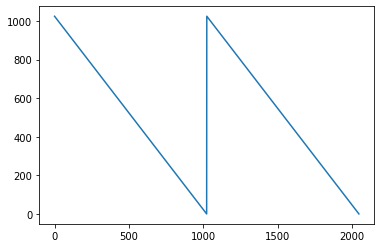

In [203]:
my_correlation=comp_acf(inp)
plt.plot(my_correlation)

# Testing for the test signal given:
## --> sine wave of frequency 441 Hz for 1s followed by a frequency of 882 Hz for 1s 

In [55]:
blockSize=1024
hopSize=512
fs=44100


f1=441
f2=882
t=1
samples1=np.arange(t * 44100)
samples2=np.arange(t * 44100)
sig_a=np.sin(2*np.pi*f1*samples1/fs)
sig_b=np.sin(2*np.pi*f2*samples2/fs)
sig=np.append(sig_a,sig_b)
samples=np.append(samples1,samples2)

blocks,times=block_audio(sig,blockSize, hopSize, fs)
calculated_correlation=comp_acf(blocks)

<ipython-input-4-1b25f361a1fc>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  out = np.array(lst)
<ipython-input-24-4759a79f0b3d>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(c) # OUTPUT NEEDS TO BE AN ARRAY OF CORRELATION ARRAYS


# Testing scipy correlation function on each block

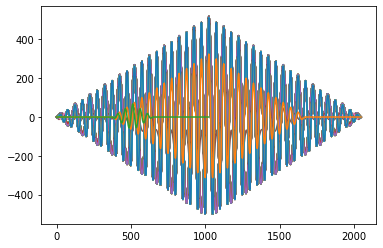

In [51]:
import scipy.signal
plt.figure()
for block in a:
    testCorr = scipy.signal.correlate(block,block)
    plt.plot(testCorr)

# Plot the calculated fundamental frequencies

<ipython-input-4-1b25f361a1fc>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  out = np.array(lst)
<ipython-input-24-4759a79f0b3d>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(c) # OUTPUT NEEDS TO BE AN ARRAY OF CORRELATION ARRAYS


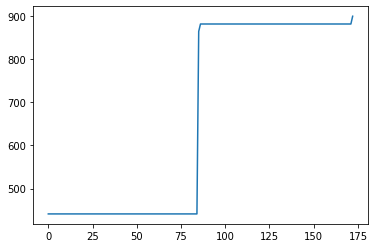

In [101]:
blockSize=1024 # AT BLOCK SIZE BELOW 258 AND HOP SIZE BELOW 128 IT BREAKS
hopSize=512
fs=44100 # AT Fs OF 88200 IT BREAKS


f1=441
f2=882
t=1
samples1=np.arange(t * fs)
samples2=np.arange(t * fs)
sig_a=np.sin(2*np.pi*f1*samples1/fs)
sig_b=np.sin(2*np.pi*f2*samples2/fs)
sig=np.append(sig_a,sig_b)
samples=np.append(samples1,samples2)
f0,ts=track_pitch_acf(sig,blockSize,hopSize, fs)

plt.plot(f0)

In [106]:
sig_a=np.sin(2*np.pi*f1*samples1/fs)
sig_b=np.sin(2*np.pi*f2*samples2/fs)
s=sig_a+sig_b
s

array([ 0.        ,  0.18812375,  0.37402312, ..., -0.55550587,
       -0.37402312, -0.18812375])

# Testing scipy.signal.find_peaks

In [60]:
peaks,_=scipy.signal.find_peaks(calculated_correlation[0])
peaks

array([100, 200, 300, 400, 500, 599, 699, 799, 898, 992])

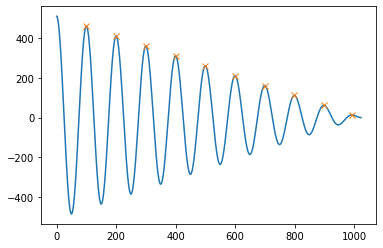

In [88]:
plt.plot(calculated_correlation[0])
plt.plot(peaks,calculated_correlation[0][peaks],"x") # plot(x_position, y_position,marker)

<ipython-input-4-1b25f361a1fc>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  out = np.array(lst)
<ipython-input-24-4759a79f0b3d>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(c) # OUTPUT NEEDS TO BE AN ARRAY OF CORRELATION ARRAYS


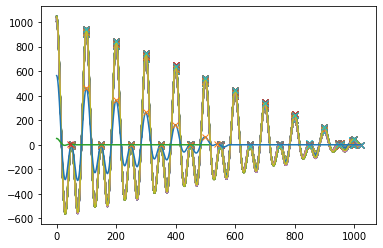

In [109]:
sig_a=np.sin(2*np.pi*f1*samples1/fs)
sig_b=np.sin(2*np.pi*f2*samples2/fs)
s=sig_a+sig_b
blockSize=1024
hopSize=512
fs=44100

f0,t=track_pitch_acf(s,blockSize, hopSize, fs)